In [1]:
import torch
import yaml
import pandas as pd
from time import time
from IPython.display import Image

import pyro
from pyro.optim import Adam
from sklearn.metrics import accuracy_score

from pearl.common import NodeValueType
from pearl.data import VariableData, BayesianNetworkDataset
from pearl.bayesnet import BayesianNetwork, from_yaml, to_yaml
from pearl.nodes.categorical import CategoricalNodeWithDirichletPrior

## Model definition using API

In [2]:
device = torch.device('cpu', 0)

asia_model = BayesianNetwork("asia", device=device)

asia_model.add_variable(CategoricalNodeWithDirichletPrior, "asia", [], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "smoke", [], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "tub", ["asia"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "lung", ["smoke"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "either", ["lung", "tub"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "bronc", ["smoke"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "xray", ["either"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "dysp", ["bronc", "either"], [], domain=["yes", "no"])

asia_model.write_dot('asia_model.dot')

In [3]:
!dot -Tpng asia_model.dot -o asia_model.png

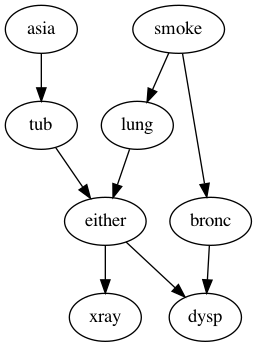

In [4]:
Image('asia_model.png')

## Serialization

In [5]:
to_yaml(asia_model, 'asia.yaml')

In [6]:
!cat asia.yaml

device:
  index: 0
  type: cpu
encodingVersion: v1.0
name: asia
nodes:
  asia:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents: []
    plates: []
    prior_params:
      alpha:
      - 1.0
      - 1.0
    type: CategoricalNodeWithDirichletPrior
  bronc:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - smoke
    plates: []
    prior_params:
      alpha:
      - - 1.0
        - 1.0
      - - 1.0
        - 1.0
    type: CategoricalNodeWithDirichletPrior
  dysp:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - bronc
    - either
    plates: []
    prior_params:
      alpha:
      - - - 1.0
          - 1.0
        - - 1.0
          - 1.0
      - - - 1.0
          - 1.0
        - - 1.0
          - 1.0
    type: CategoricalNodeWithDirichletPrior
  either:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - lung
    - tub
    plates: []
    prior_params:
      alpha:
      - - - 1.0
          - 1.0
        -

## De-serialization

The yaml file created in the earlier step can be used to instantiate a `BayesianNetwork` object. Note that the yaml file was produced by first creating a `BayesianNetwork` object using the API and then serializing it. We could have written the yaml file directly. A minimal yaml file which defines the same `BayesianNetwork` object is given in `asia_minimal.yaml` file. The optional parameters of the node constructors can be omitted whether the object is being constructed using API or a yaml file.

In [7]:
!cat asia_minimal.yaml

device:
  index: 0
  type: cpu
encodingVersion: v1.0
name: asia
plates: {}
nodes:
  asia:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: []
    plates: []
  smoke:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: []
    plates: []
  tub:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: ['asia']
    plates: []
  lung:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: ['smoke']
    plates: []
  either:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: ['lung', 'tub']
    plates: []
  bronc:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: ['smoke']
    plates: []
  xray:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: ['either']
    plates: []
  dysp:
    type: CategoricalNodeWithDirichletPrior
    domain: ['yes', 'no']
    parents: ['bronc', 'either']


In [8]:
asia_model1 = from_yaml('asia.yaml')
asia_model2 = from_yaml('asia_minimal.yaml')
assert isinstance(asia_model1, BayesianNetwork)
assert isinstance(asia_model2, BayesianNetwork)

## Train/test models loaded from yaml

### Download/prepare dataset

In [9]:
def converter(x):
    if x == 'yes':
        return 0
    else:
        return 1

try:
    asia_dataset = torch.load("asia_dataset.pkl")
except:    
    df = pd.read_csv(
        "http://www.ccd.pitt.edu/wiki/images/ASIA10k.csv",
        converters = {k:converter for k in range(8)}
    )
    variable_dict = {
        k: VariableData(
            NodeValueType.CATEGORICAL,
            torch.tensor(df[k].to_numpy(), device=device).float(),
            ["yes","no"],
        )
        for k in df.columns
    }
    asia_dataset = BayesianNetworkDataset(variable_dict)
    torch.save(asia_dataset, "asia_dataset.pkl")
    
num_train_instances = int(len(asia_dataset) * 0.8)
num_test_instances = len(asia_dataset) - num_train_instances
train_dataset, test_dataset = asia_dataset.split((num_train_instances, num_test_instances))

## Train models

In [10]:
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer1 = Adam(adam_params)
optimizer2 = Adam(adam_params)

In [11]:
pyro.set_rng_seed(101)
start=time()
asia_model1.train(
    dataset=train_dataset, 
    optimizer=optimizer1, 
    num_steps=1000, 
    subsample_size=None,
)
end=time()
print(f"training time is {end-start}")
to_yaml(asia_model1, 'asia_trained.yaml')

  9%|▉         | 94/1000 [00:01<00:17, 51.25it/s]svi_step: 100
elbo: 47309.8499731943
 20%|█▉        | 196/1000 [00:03<00:14, 53.76it/s]svi_step: 200
elbo: 29399.076385498047
 30%|██▉       | 295/1000 [00:05<00:15, 45.70it/s]svi_step: 300
elbo: 27899.75730639696
 40%|███▉      | 395/1000 [00:07<00:12, 47.25it/s]svi_step: 400
elbo: 24857.874522179365
 50%|████▉     | 495/1000 [00:10<00:10, 50.04it/s]svi_step: 500
elbo: 23603.77119256556
 59%|█████▉    | 594/1000 [00:12<00:08, 50.52it/s]svi_step: 600
elbo: 30037.96249936521
 70%|██████▉   | 696/1000 [00:14<00:06, 50.61it/s]svi_step: 700
elbo: 23218.37414830923
 80%|███████▉  | 796/1000 [00:15<00:03, 53.00it/s]svi_step: 800
elbo: 33649.2723094821
 90%|████████▉ | 898/1000 [00:17<00:01, 53.01it/s]svi_step: 900
elbo: 19963.468831002712
 99%|█████████▉| 994/1000 [00:19<00:00, 52.96it/s]svi_step: 1000
elbo: 30196.167680084705
100%|██████████| 1000/1000 [00:19<00:00, 50.39it/s]
training time: 19.85738182067871


training time is 19.859366178512573


In [12]:
pyro.set_rng_seed(101)
start=time()
asia_model2.train(
    dataset=train_dataset, 
    optimizer=optimizer2, 
    num_steps=1000, 
    subsample_size=None,
)
end=time()
print(f"training time is {end-start}")
to_yaml(asia_model2, 'asia_minimal_trained.yaml')

 10%|▉         | 95/1000 [00:01<00:17, 50.82it/s]svi_step: 100
svi_step: 100
elbo: 51782.52207753062
elbo: 51782.52207753062
 20%|█▉        | 196/1000 [00:03<00:15, 53.21it/s]svi_step: 200
svi_step: 200
elbo: 28254.03274296969
elbo: 28254.03274296969
 30%|██▉       | 298/1000 [00:05<00:13, 53.04it/s]svi_step: 300
svi_step: 300
elbo: 35459.92137250304
elbo: 35459.92137250304
 39%|███▉      | 394/1000 [00:07<00:11, 53.09it/s]svi_step: 400
svi_step: 400
elbo: 26820.53262232244
elbo: 26820.53262232244
 50%|████▉     | 497/1000 [00:09<00:11, 45.25it/s]svi_step: 500
svi_step: 500
elbo: 21151.638860344887
elbo: 21151.638860344887
 60%|█████▉    | 597/1000 [00:11<00:07, 51.54it/s]svi_step: 600
svi_step: 600
elbo: 27877.231349021196
elbo: 27877.231349021196
 70%|██████▉   | 696/1000 [00:13<00:05, 51.78it/s]svi_step: 700
svi_step: 700
elbo: 21700.94114392996
elbo: 21700.94114392996
 80%|███████▉  | 798/1000 [00:15<00:03, 51.46it/s]svi_step: 800
svi_step: 800
elbo: 20565.12324091792
elbo: 20565.1

training time is 19.9356689453125


## Test model

In [13]:
true_labels = test_dataset["tub"].clone().detach()
test_dataset["tub"] = torch.zeros(len(test_dataset)) # zero out the labels in test-dataset

pyro.set_rng_seed(101)
start=time()
_, prediction_MAP_assignment1, _ = asia_model1.predict(
    test_dataset, 
    ["tub"],
)
end=time()
print(f"time taken for predictions is {end-start}")
accuracy1 = accuracy_score(true_labels.cpu().numpy(), prediction_MAP_assignment1["tub"].cpu().numpy())
print(f"accuracy of 'asia_model1' is {accuracy1}")

time taken for predictions is 1.0736980438232422
accuracy of 'asia_model1' is 0.9985


In [14]:
pyro.set_rng_seed(101)
start=time()
_, prediction_MAP_assignment2, _ = asia_model2.predict(
    test_dataset, 
    ["tub"],
)
end=time()
print(f"time taken for predictions is {end-start}")
accuracy2 = accuracy_score(true_labels.cpu().numpy(), prediction_MAP_assignment2["tub"].cpu().numpy())
print(f"accuracy of 'asia_model2' is {accuracy2}")

time taken for predictions is 1.0651459693908691
accuracy of 'asia_model2' is 0.9985


## Save trained model to yaml

In [15]:
to_yaml(asia_model1, 'asia_trained.yaml')
to_yaml(asia_model2, 'asia_minimal_trained.yaml')

In [16]:
!cat asia_trained.yaml

device:
  index: 0
  type: cpu
encodingVersion: v1.0
name: asia
nodes:
  asia:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents: []
    plates: []
    prior_params:
      alpha:
      - 0.20141923427581787
      - 3.667067766189575
    type: CategoricalNodeWithDirichletPrior
  bronc:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - smoke
    plates: []
    prior_params:
      alpha:
      - - 3.0698866844177246
        - 2.1459221839904785
      - - 1.5987387895584106
        - 3.6322672367095947
    type: CategoricalNodeWithDirichletPrior
  dysp:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - bronc
    - either
    plates: []
    prior_params:
      alpha:
      - - - 4.343966007232666
          - 0.7461813688278198
        - - 3.925771474838257
          - 1.1586215496063232
      - - - 3.5261497497558594
          - 1.6487715244293213
        - - 0.6600939035415649
          - 3.9159398078918457
    type: Categorical

In [17]:
!cat asia_minimal_trained.yaml

device:
  index: 0
  type: cpu
encodingVersion: v1.0
name: asia
nodes:
  asia:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents: []
    plates: []
    prior_params:
      alpha:
      - 0.20141923427581787
      - 3.667067766189575
    type: CategoricalNodeWithDirichletPrior
  bronc:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - smoke
    plates: []
    prior_params:
      alpha:
      - - 3.0698866844177246
        - 2.1459221839904785
      - - 1.5987387895584106
        - 3.6322672367095947
    type: CategoricalNodeWithDirichletPrior
  dysp:
    domain:
    - 'yes'
    - 'no'
    observed: true
    parents:
    - bronc
    - either
    plates: []
    prior_params:
      alpha:
      - - - 4.343966007232666
          - 0.7461813688278198
        - - 3.925771474838257
          - 1.1586215496063232
      - - - 3.5261497497558594
          - 1.6487715244293213
        - - 0.6600939035415649
          - 3.9159398078918457
    type: Categorical